In [5]:
import tensorflow as tf
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import sys, getopt
from keras import backend as K


Using TensorFlow backend.


# Data Preparation

The file is read by pandas module, the **val** column in the dataframe is the sales column and **ind\*** are the feature columns. <br>
This data is collected for an uniform timestamp.
<br>
The following data depicts sale for each uniform timestamp, so our job will be to predict sales i.e **val** for next 10 timestamps.
<br>
Number of future predictions to be made is called **horizon**. So our horizon here will be 10.

### 1. Reading Data

In [16]:
df = pd.read_csv('data.csv')

In [17]:
df 

val     ind0     ind1     ind2
0     0.53304  0.53309  0.53116  0.53130
1     0.53223  0.53304  0.53209  0.53302
2     0.53243  0.53256  0.53225  0.53229
3     0.53252  0.53252  0.53235  0.53242
4     0.53244  0.53252  0.53238  0.53249
5     0.53286  0.53294  0.53243  0.53244
6     0.53270  0.53287  0.53266  0.53286
7     0.53243  0.53266  0.53224  0.53266
8     0.53244  0.53248  0.53239  0.53243
9     0.53246  0.53273  0.53246  0.53257
10    0.53248  0.53256  0.53248  0.53248
11    0.53249  0.53251  0.53237  0.53250
12    0.53249  0.53257  0.53245  0.53247
13    0.53247  0.53255  0.53241  0.53248
14    0.53209  0.53247  0.53208  0.53246
15    0.53165  0.53209  0.53165  0.53207
16    0.53193  0.53197  0.53165  0.53166
17    0.53177  0.53197  0.53174  0.53192
18    0.53163  0.53178  0.53161  0.53178
19    0.53161  0.53166  0.53145  0.53165
20    0.53143  0.53161  0.53142  0.53161
21    0.53136  0.53145  0.53135  0.53144
22    0.53142  0.53147  0.53133  0.53137
23    0.53146  0.53149  0.53140  0.53142
24    0.53150  0.53153  0.53142  0.53146
25    0.53151  0.53162  0.53149  0.53151
26    0.53144  0.53150  0.53135  0.53149
27    0.53135  0.53144  0.53134  0.53144
28    0.53130  0.53136  0.53128  0.53135
29    0.53151  0.53153  0.53133  0.53135
...       ...      ...      ...      ...
4108  0.54687  0.54687  0.54682  0.54687
4109  0.54692  0.54692  0.54683  0.54687
4110  0.54697  0.54697  0.54692  0.54692
4111  0.54702  0.54707  0.54697  0.54702
4112  0.54707  0.54712  0.54704  0.54706
4113  0.54707  0.54712  0.54701  0.54712
4114  0.54707  0.54707  0.54704  0.54704
4115  0.54732  0.54732  0.54717  0.54717
4116  0.54722  0.54732  0.54716  0.54732
4117  0.54722  0.54727  0.54717  0.54727
4118  0.54717  0.54722  0.54712  0.54722
4119  0.54712  0.54721  0.54709  0.54717
4120  0.54727  0.54727  0.54712  0.54712
4121  0.54727  0.54727  0.54722  0.54722
4122  0.54732  0.54732  0.54727  0.54727
4123  0.54722  0.54722  0.54709  0.54712
4124  0.54727  0.54727  0.54722  0.54722
4125  0.54717  0.54727  0.54716  0.54727
4126  0.54722  0.54722  0.54716  0.54716
4127  0.54719  0.54719  0.54719  0.54719
4128  0.54717  0.54720  0.54717  0.54720
4129  0.54700  0.54709  0.54699  0.54709
4130  0.54672  0.54701  0.54672  0.54701
4131  0.54665  0.54673  0.54665  0.54673
4132  0.54667  0.54667  0.54667  0.54667
4133  0.54655  0.54659  0.54655  0.54659
4134  0.54661  0.54661  0.54659  0.54659
4135  0.54659  0.54660  0.54658  0.54660
4136  0.54672  0.54674  0.54667  0.54667
4137  0.54670  0.54677  0.54669  0.54671

[4138 rows x 4 columns]

### 2. Converting dataset into numpy array

In [21]:
def extract_values(data):
    """Required data is extracted and returned as a numpy array 
    """
    df = data.filter(regex=('val|ind.*'))
    
    #Extracting values
    dataset = df.values
    dataset = dataset.astype('float32')
    return dataset

### 3. Actual data preparation for making it a time-series problem.

For time series prediction using LSTM we need to define a **window-size** or **look-back** which accounts for how far the model will look or *see* into the data to make its next prediction[s]. <br>
Here we will use the value of **look_back** as 20. There is no hard and fast rule for selecting this parameter.
<br>
By setting it to 20 our model will look back to 20 timestamps of data to make its next 10 predictions. 

In [19]:
def create_dataset(dataset):
    """Data preparation function
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-(output_layer+look_back)-1):
        a = dataset[i:(i+look_back),feature_indices]                      
        dataX.append(a)
        b = dataset[(i+look_back):(i+look_back)+output_layer, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

### 4. Splitting data into train-test set.
This function will split the dataset into 70-30 ratio and will call the **create_dataset** function to prepare the data. 
<br>The shape of the data will be : [n_samples, look_back, features] <br>
**Feature Indices** contain the indices of columns to choose as features. All the columns are selected as features in our cases. One may wonder why choose the **val** column as a feature.
<br>
The reason behind is that for future predictions our *last* sales predictions should also be accounted for.

In [23]:
def split_dataset(dataset):
    """Splitting dataset into Train and Test
    """
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    
    testX, testY = create_dataset(test)    
    trainX, trainY = create_dataset(train)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1], len(feature_indices))) 
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(feature_indices))) 
    
    print "Train data shape : ",trainX.shape
    print "Test data shape  : ", testX.shape

    return trainX, trainY, testX, testY

In [26]:
output_layer = 10
feature_indices = [0,1,2,3]
look_back = 20

dataset = extract_values(df)
trainX, trainY, testX, testY = split_dataset(dataset)

Train data shape :  (2741, 20, 4)
Test data shape  :  (1335, 20, 4)


# Training using Keras

Now we will train our prepared dataset using a deep learning libarary **Keras**


### 1. Custom loss function 
We have used a custom loss function which will reduce the squared error of the **average** of the horizon or 10 predictions made by the model. 

In [28]:
def custom_loss(y_true, y_pred):
    y_true = tf.reduce_mean(y_true,axis=1)
    y_pred = tf.reduce_mean(y_pred,axis=1)
    return K.mean(K.square(y_pred - y_true), axis=-1)

### 2. Training process 
For demonstration purposes the model is trained only for 10 epochs. <br>
Number of LSTM units used = 1. <br>
For better generalisation you can use dropout too. 

In [29]:
epochs = 10
with tf.device('/gpu:0'):     
        model = Sequential()
        model.add(LSTM(1, input_shape=(look_back,len(feature_indices))))   
        model.add(Dense(output_layer))
        model.compile(loss=custom_loss , optimizer= 'adam')
        model.fit(trainX, trainY, epochs=epochs, batch_size=10, verbose=2, validation_split=0.2)

Train on 2192 samples, validate on 549 samples
Epoch 1/10
16s - loss: 0.0990 - val_loss: 0.0199
Epoch 2/10
5s - loss: 0.0046 - val_loss: 1.5683e-04
Epoch 3/10
5s - loss: 2.0390e-05 - val_loss: 5.2097e-06
Epoch 4/10
6s - loss: 4.4943e-06 - val_loss: 4.1857e-06
Epoch 5/10
6s - loss: 4.4877e-06 - val_loss: 4.4422e-06
Epoch 6/10
5s - loss: 4.4903e-06 - val_loss: 4.3466e-06
Epoch 7/10
5s - loss: 4.4839e-06 - val_loss: 4.4581e-06
Epoch 8/10
5s - loss: 4.4871e-06 - val_loss: 4.4157e-06
Epoch 9/10
5s - loss: 4.4863e-06 - val_loss: 3.8879e-06
Epoch 10/10
5s - loss: 4.4879e-06 - val_loss: 4.1788e-06


### 3. Compiling predictions
For better plots and understanding of our model's fitting we have taken average of the 10 predictions made by the model.
<br>
So for each training sample instead of having 10 points corresponding to it, there is only one point which is the average of the 10 points/predictions.

In [31]:
def compile_predictions(trainX,trainY, testX, testY,model):
    """Averaging the predictions for one data point,
    because for one instance, model predicts 10 values (horizon),
    To make the plot look nice we take average of the horizon for each data point/instance.
    """
    trainY = trainY
    trainY = [np.average(i) for i in trainY]
    testY = testY
    testY = [np.average(i) for i in testY]
    trainPredict = model.predict(trainX)
    trainPredict = [np.average(i) for i in trainPredict]
    testPredict = model.predict(testX)
    testPredict = [np.average(i) for i in testPredict]
    
    return trainY, trainPredict, testY, testPredict

### 4. Evaluating our model
The model's accuracy can be calculated by its RMSE or **mean squared error** over the training and test samples.
The lesser is the error rate, better has our model fitted over the data.

In [32]:
trainY, trainPredict, testY, testPredict = \
                compile_predictions(trainX,trainY,testX,testY,model)

In [33]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print("Train Score: {:e} RMSE".format(trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print("Test Score: {:e} RMSE".format(testScore))

Train Score: 2.102039e-03 RMSE
Test Score: 5.245794e-03 RMSE


# Visualizations
Now lets plot the training and test data with against the predictions by our model.

In [34]:
#Plot Training curve
def plot_train(trainY, trainPredict):
        #Plot Training curve
    fig, ax = plt.subplots()
    ax.plot(trainY, label='Actual Points')
    ax.plot(trainPredict, label = 'Predicted Points')
    ax = plt.gca()
    ax.set_xlabel('#_instances', fontsize = 20)
    ax.set_ylabel('', fontsize = 20)
    #fig_size = plt.rcParams["figure.figsize"]
    #fig_size[0] = 20
    #fig_size[1] = 10
    #plt.rcParams["figure.figsize"] = fig_size
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_rotation('horizontal')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)  
    plt.legend()
    plt.legend(loc='upper right')
    plt.legend(prop={'size':'20'})
    #plt.ylim(0,1)
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.savefig('./figures/train.png')
    plt.show()

#Plot Training curve
def plot_test(testY, testPredict):
       #Plot Training curve
    fig, ax = plt.subplots()
    ax.plot(testY, label='Test Points')
    ax.plot(testPredict, label = 'Predicted Points')
    ax = plt.gca()
    ax.set_xlabel('#_instances', fontsize = 20)
    ax.set_ylabel('', fontsize = 20)
    
    #fig_size = plt.rcParams["figure.figsize"]
    #fig_size[0] = 20
    #fig_size[1] = 10
    #plt.rcParams["figure.figsize"] = fig_size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_rotation('horizontal')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)  
    plt.legend()
    plt.legend(loc='upper right')
    plt.legend(prop={'size':'20'})
    #plt.ylim(0,1)
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.savefig('./figures/test.png')
    plt.show()

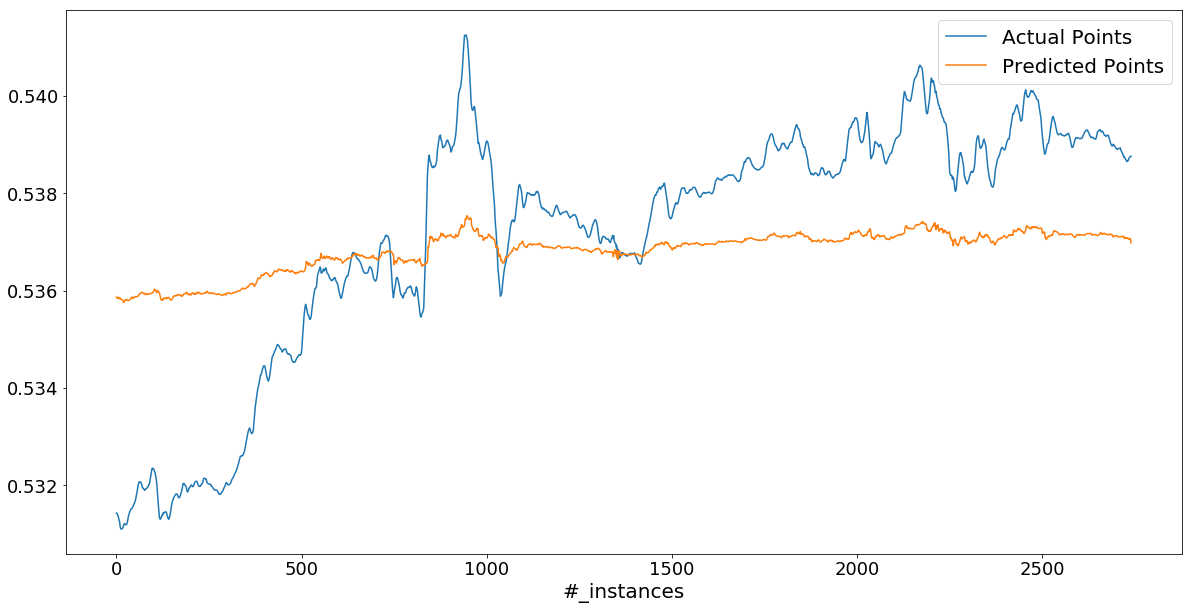

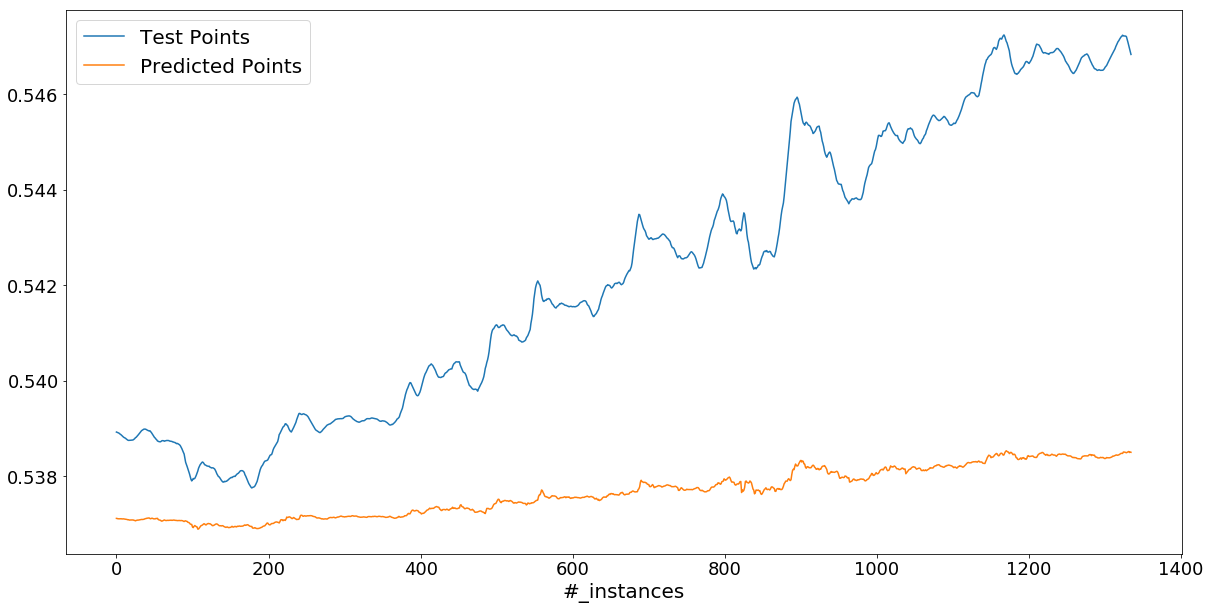

In [35]:
plot_train(trainY,trainPredict)  
plot_test(testY, testPredict)

# Results
You can see the line hasnt fitted best yet. There is still room for improvement by hyper-parameter tuning. 
But the predicted results are differ by the scale of two-decimal digits. <br>
So thats pretty impressive. 